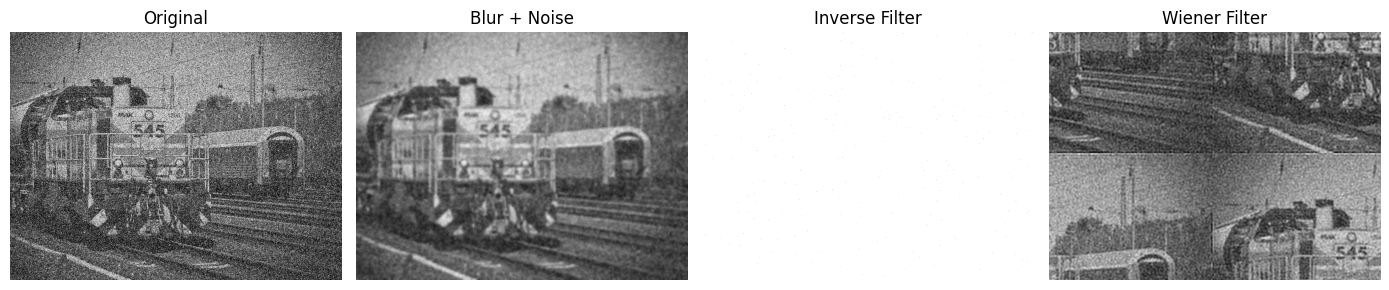

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --------- Functions ---------

def add_gaussian_noise(image, mean=0, var=0.001):
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, image.shape)
    noisy = image + gauss
    return np.clip(noisy, 0, 1)

def gaussian_blur_kernel(size=9, sigma=2):
    k = cv2.getGaussianKernel(size, sigma)
    kernel = k @ k.T
    kernel /= np.sum(kernel)   # normalize
    return kernel

def pad_kernel(kernel, shape):
    pad = np.zeros(shape, dtype=np.float32)
    kh, kw = kernel.shape
    # put kernel in top-left corner
    pad[:kh, :kw] = kernel
    # shift kernel to center
    pad = np.fft.ifftshift(pad)
    return pad

def inverse_filtering(degraded, H, eps=1e-5):
    G = np.fft.fft2(degraded)
    H = np.where(np.abs(H) < eps, eps, H)  # avoid division by zero
    F_hat = G / H
    f_hat = np.fft.ifft2(F_hat)
    return np.abs(f_hat)

def wiener_filter(degraded, H, K=0.01):
    G = np.fft.fft2(degraded)
    H_conj = np.conj(H)
    denominator = (np.abs(H) ** 2) + K
    F_hat = (H_conj / denominator) * G
    f_hat = np.fft.ifft2(F_hat)
    return np.abs(f_hat)

# --------- Main Program ---------

# Load image in grayscale and normalize
image_path = 'noise.jpg'  # <-- your image path here
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
image = image.astype(np.float32) / 255.0

# Create Gaussian blur kernel
kernel = gaussian_blur_kernel(size=15, sigma=3)  # slightly larger kernel for effect

# Apply blur + noise (degraded image)
blurred = cv2.filter2D(image, -1, kernel)   # blur
noisy = add_gaussian_noise(blurred, var=0.001)  # add noise

# FFT of padded kernel
H = pad_kernel(kernel, image.shape)
H = np.fft.fft2(H)

# Apply inverse filter and Wiener filter
restored_inverse = inverse_filtering(noisy, H)
restored_inverse = np.clip(restored_inverse, 0, 1)

restored_wiener = wiener_filter(noisy, H, K=0.01)
restored_wiener = np.clip(restored_wiener, 0, 1)

# --------- Plot results ---------

plt.figure(figsize=(14, 6))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Blur + Noise")
plt.imshow(noisy, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Inverse Filter")
plt.imshow(restored_inverse, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Wiener Filter")
plt.imshow(restored_wiener, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


Degraded: PSNR=11.86 dB, SSIM=0.0479
Inverse filter: PSNR=4.74 dB, SSIM=0.0040
Wiener filter: PSNR=12.08 dB, SSIM=0.1013


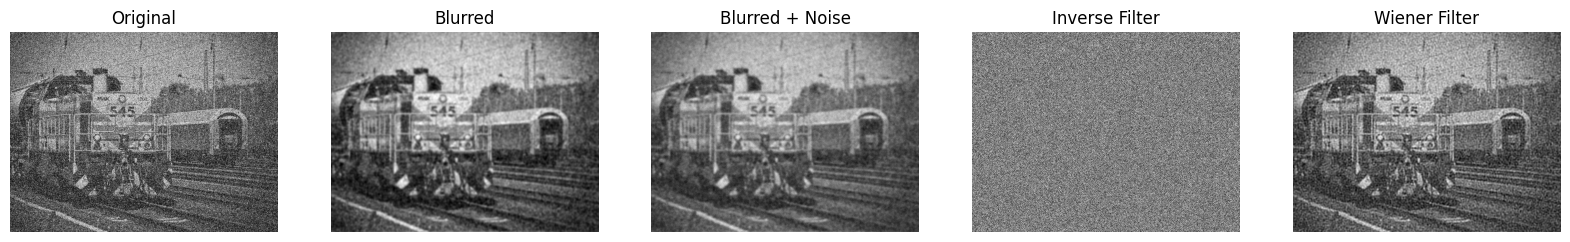

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, metrics
from scipy.signal import fftconvolve
from numpy.fft import fft2, ifft2
import os
from imageio import imwrite

def gaussian_kernel(size=25, sigma=3):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def psf_pad(psf, shape):
    pad = np.zeros(shape)
    psf_shape = psf.shape
    pad[:psf_shape[0], :psf_shape[1]] = psf
    for axis, axis_size in enumerate(psf_shape):
        pad = np.roll(pad, -axis_size//2, axis=axis)
    return pad

def add_gaussian_noise(image, sigma):
    noisy = image + np.random.normal(0, sigma, image.shape)
    return np.clip(noisy, 0, 1)

def inverse_filter(blurred_noisy, H, eps=1e-3):
    G = fft2(blurred_noisy)
    H_abs = np.abs(H)
    H_safe = np.where(H_abs < eps, eps, H)
    F_hat = G / H_safe
    f_est = np.real(ifft2(F_hat))
    return np.clip(f_est, 0, 1)

def wiener_filter(blurred_noisy, H, K):
    G = fft2(blurred_noisy)
    H_conj = np.conj(H)
    denom = (np.abs(H)**2 + K)
    W = H_conj / denom
    F_hat = W * G
    f_est = np.real(ifft2(F_hat))
    return np.clip(f_est, 0, 1)

def compute_metrics(ref, test):
    psnr = metrics.peak_signal_noise_ratio(ref, test, data_range=1.0)
    ssim = metrics.structural_similarity(ref, test, data_range=1.0)
    mse = metrics.mean_squared_error(ref, test)
    return psnr, ssim, mse


img = io.imread("noise.jpg")

# If image has 4 channels (RGBA), drop alpha
if img.ndim == 3 and img.shape[2] == 4:
    img = img[:, :, :3]

# Convert to grayscale if needed
if img.ndim == 3:
    img = color.rgb2gray(img)

# Normalize to [0,1]
img = (img - img.min()) / (img.max() - img.min())

# Create PSF (Gaussian blur) and blur the image
psf = gaussian_kernel(size=25, sigma=3)
psf_p = psf_pad(psf, img.shape)
img_blurred = np.real(ifft2(fft2(img) * fft2(psf_p)))
img_blurred = np.clip(img_blurred, 0, 1)

# Add Gaussian noise
noise_sigma = 0.03
img_degraded = add_gaussian_noise(img_blurred, sigma=noise_sigma)

# Compute transfer function H
H = fft2(psf_p)

# Apply Inverse filter
inv_restored = inverse_filter(img_degraded, H)

# Apply Wiener filter
noise_var = noise_sigma**2
signal_var = np.var(img)
K = noise_var / (signal_var + 1e-12)
wiener_restored = wiener_filter(img_degraded, H, K)

# Metrics
metrics_degraded = compute_metrics(img, img_degraded)
metrics_inv = compute_metrics(img, inv_restored)
metrics_wiener = compute_metrics(img, wiener_restored)

print("Degraded: PSNR=%.2f dB, SSIM=%.4f" % (metrics_degraded[0], metrics_degraded[1]))
print("Inverse filter: PSNR=%.2f dB, SSIM=%.4f" % (metrics_inv[0], metrics_inv[1]))
print("Wiener filter: PSNR=%.2f dB, SSIM=%.4f" % (metrics_wiener[0], metrics_wiener[1]))

# Show images
fig, axs = plt.subplots(1,5, figsize=(20,5))
axs[0].imshow(img, cmap='gray'); axs[0].set_title("Original"); axs[0].axis('off')
axs[1].imshow(img_blurred, cmap='gray'); axs[1].set_title("Blurred"); axs[1].axis('off')
axs[2].imshow(img_degraded, cmap='gray'); axs[2].set_title("Blurred + Noise"); axs[2].axis('off')
axs[3].imshow(inv_restored, cmap='gray'); axs[3].set_title("Inverse Filter"); axs[3].axis('off')
axs[4].imshow(wiener_restored, cmap='gray'); axs[4].set_title("Wiener Filter"); axs[4].axis('off')
plt.show()